# Image classifier



In this project, we wll train an image classifier to recognize different species of flowers. we can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice we'd train this classifier, then export it for use in Command line. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, here are a few examples below. 

<img src='https://drive.google.com/uc?id=1QVLlX2SGSI2JCE4HMSyYlm-fHO-UhLFJ' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use the trained model to perform inference on flower images.


In [ ]:
# The new version of dataset is only available in the tfds-nightly package.
#%pip --no-cache-dir install tfds-nightly --user
#!pip install tensorflow  --user

## Import Resources

In [ ]:
# Make all other necessary imports.
%matplotlib inline

#to render higher resolution images
%config InlineBackend.figure_format = 'retina'
import numpy

from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import json
import os 

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
tfds.disable_progress_bar()

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Logger info
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
from keras.layers import Activation, Dense,Dropout,Conv2D, MaxPooling2D
from tensorflow.keras import layers
from keras.models import Sequential

## Load the Dataset

We used `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  We also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks (mobilenet_v2).

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but we still need to normalize and resize the images to the appropriate size.

In [ ]:

# Download data to default local directory "~/tensorflow_datasets"

dataset, dataset_info = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)

train= dataset['test']
test= dataset['train']
validation=  dataset['validation']


## Explore the Dataset

In [ ]:

# Get the number of examples in each set from the dataset info.
num_training_examples = dataset_info.splits['test'].num_examples
num_testing_examples = dataset_info.splits['train'].num_examples
num_validation_examples = dataset_info.splits['validation'].num_examples

# Get the number of classes in the dataset from the dataset info.
no_of_classes=dataset_info.features['label'].num_classes
print("num_training_examples:",num_training_examples)
print("\nnum_testing_examples:",num_testing_examples)
print("\nnum_validation_examples:",num_validation_examples)
print("\nNum of classes:",no_of_classes)

num_training_examples: 6149

num_testing_examples: 1020

num_validation_examples: 1020

Num of classes: 102


In [ ]:

# Print the shape and corresponding label of 5 images in the training set.
for image, label in train.take(5):
    label = int(label)
    print('\u2022Image shape:',image.shape)
    print('\u2022Image label:',label)
    print("\n")

•Image shape: (542, 500, 3)
•Image label: 40


•Image shape: (748, 500, 3)
•Image label: 76


•Image shape: (500, 600, 3)
•Image label: 42


•Image shape: (500, 702, 3)
•Image label: 63


•Image shape: (500, 667, 3)
•Image label: 94




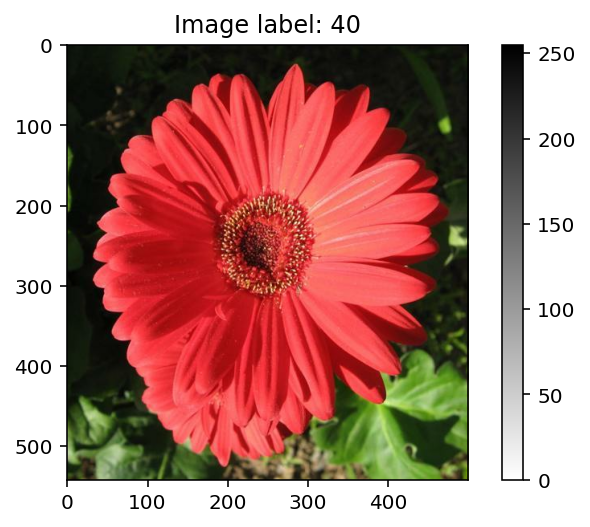

In [ ]:
# Set the title of the plot to the corresponding image label. 
for image, label in train.take(1):
    label = int(label)

plt.imshow(image, cmap= plt.cm.binary)
plt.title('Image label: {}'.format(label))
plt.colorbar()
plt.show()



### Label Mapping

We also need to load in a mapping from label to category name. We can find this in the file `label_map.json`. This will give us a dictionary mapping the integer coded labels to the actual names of the flowers.

In [ ]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

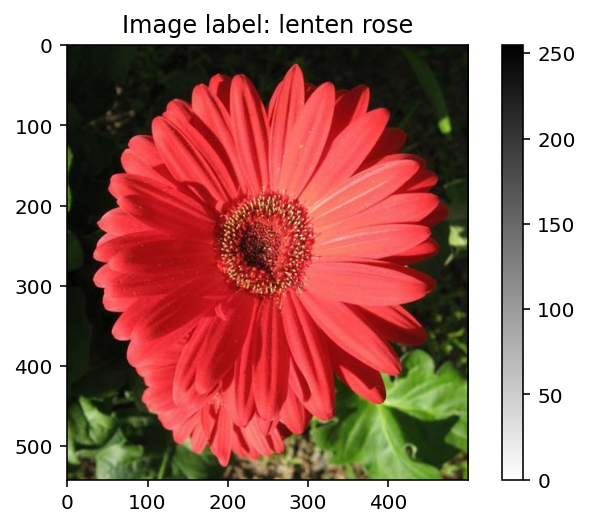

In [ ]:
# Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 
for image, label in train.take(1):
    label = int(label)

plt.imshow(image, cmap= plt.cm.binary)
plt.title('Image label: {}'.format(class_names[str(label)]))
plt.colorbar()
plt.show()



## Create Pipeline

In [ ]:
# Create a pipeline for each set.
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224)) 
    image /= 255
    return image, label
    
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

#caches the dataset in memory (avoids having to reapply preprocessing transformations to the input)

training_batches= train.cache().shuffle(num_training_examples//4).map(normalize).batch(batch_size).prefetch(tf.data.AUTOTUNE)

validation_batches = validation.cache().map(normalize).batch(batch_size).prefetch(tf.data.AUTOTUNE)
testing_batches = test.cache().map(normalize).batch(batch_size).prefetch(tf.data.AUTOTUNE)


# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. we wiil use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.



## MobileNet

In [ ]:
# Build and train your network.


URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224,3))

feature_extractor.trainable = False

model = tf.keras.Sequential(feature_extractor)

model.add(Dense(no_of_classes, kernel_regularizer='l1_l2',activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer = "adam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=6)
history = model.fit(training_batches,
                    epochs = 50,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])


Epoch 1/50
193/193 [==============================] - 25s 121ms/step - loss: 1.9421 - accuracy: 0.5991 - val_loss: 1.0097 - val_accuracy: 0.7814
Epoch 2/50
193/193 [==============================] - 12s 64ms/step - loss: 0.5375 - accuracy: 0.9084 - val_loss: 0.6569 - val_accuracy: 0.8549
Epoch 3/50
193/193 [==============================] - 12s 63ms/step - loss: 0.3100 - accuracy: 0.9514 - val_loss: 0.5151 - val_accuracy: 0.8824
Epoch 4/50
193/193 [==============================] - 12s 63ms/step - loss: 0.2059 - accuracy: 0.9715 - val_loss: 0.4848 - val_accuracy: 0.8873
Epoch 5/50
193/193 [==============================] - 12s 63ms/step - loss: 0.1483 - accuracy: 0.9815 - val_loss: 0.4344 - val_accuracy: 0.8951
Epoch 6/50
193/193 [==============================] - 12s 64ms/step - loss: 0.1096 - accuracy: 0.9904 - val_loss: 0.4152 - val_accuracy: 0.9029
Epoch 7/50
193/193 [==============================] - 12s 64ms/step - loss: 0.0844 - accuracy: 0.9943 - val_loss: 0.3974 - val_accuracy

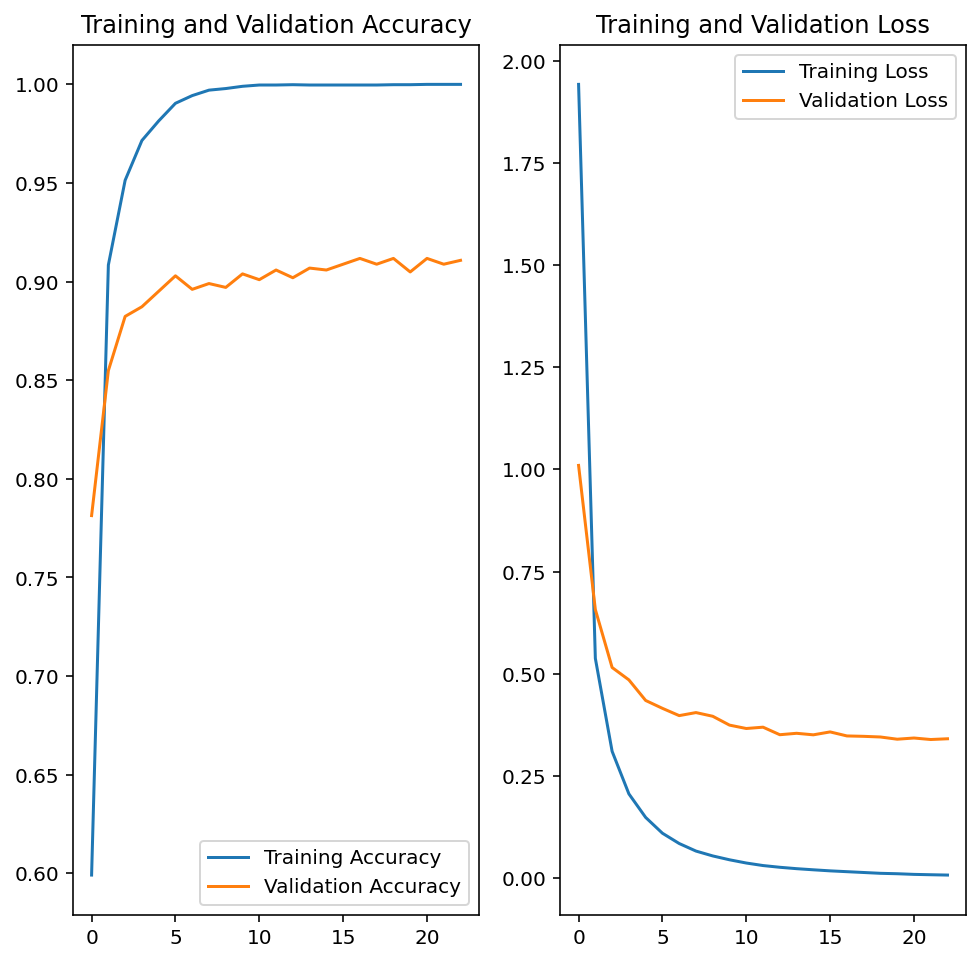

In [ ]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [ ]:
# Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

32/32 [==============================] - 4s 119ms/step - loss: 0.3948 - accuracy: 0.8843

Loss on the TEST Set: 0.395
Accuracy on the TEST Set: 88.431%



## Inception

In [ ]:
URL= "https://tfhub.dev/google/tf2-preview/inception_v3/classification/4"

IMAGENET = hub.KerasLayer(URL, input_shape=(224, 224,3))
IMAGENET.trainable = False

model_2 = tf.keras.Sequential(IMAGENET)
model_2.add(Dense(no_of_classes, kernel_regularizer='l1_l2',activation = 'softmax'))

In [ ]:

model_2.compile(optimizer = "ADAMax",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)


history = model_2.fit(training_batches,
                    epochs = 50,
                    validation_data=validation_batches,
                    callbacks=[early_stopping])

Epoch 1/50
193/193 [==============================] - 66s 142ms/step - loss: 3.1028 - accuracy: 0.3444 - val_loss: 2.4045 - val_accuracy: 0.4216
Epoch 2/50
193/193 [==============================] - 17s 87ms/step - loss: 1.4876 - accuracy: 0.6393 - val_loss: 1.6912 - val_accuracy: 0.5765
Epoch 3/50
193/193 [==============================] - 17s 87ms/step - loss: 1.0392 - accuracy: 0.7499 - val_loss: 1.3772 - val_accuracy: 0.6559
Epoch 4/50
193/193 [==============================] - 17s 87ms/step - loss: 0.8002 - accuracy: 0.8089 - val_loss: 1.2183 - val_accuracy: 0.6971
Epoch 5/50
193/193 [==============================] - 17s 87ms/step - loss: 0.6472 - accuracy: 0.8476 - val_loss: 1.1121 - val_accuracy: 0.7186
Epoch 6/50
193/193 [==============================] - 17s 87ms/step - loss: 0.5378 - accuracy: 0.8758 - val_loss: 1.0344 - val_accuracy: 0.7353
Epoch 7/50
193/193 [==============================] - 17s 87ms/step - loss: 0.4547 - accuracy: 0.8987 - val_loss: 0.9644 - val_accuracy

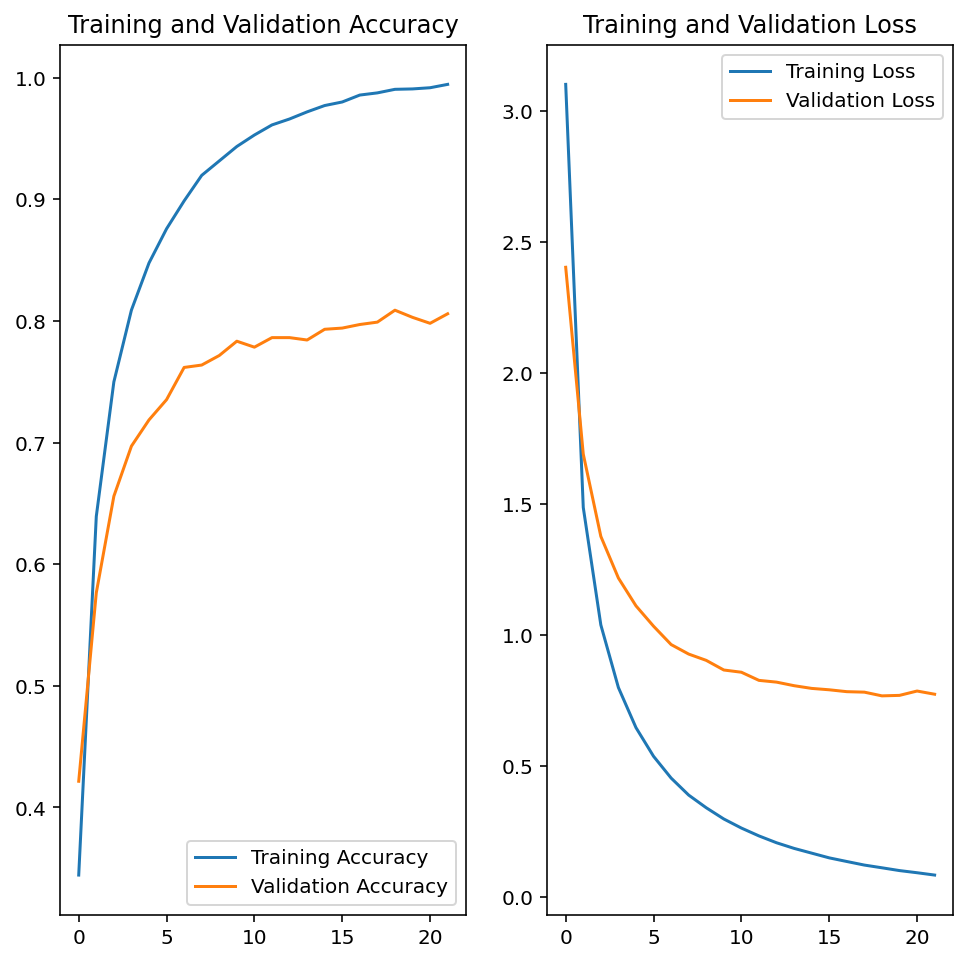

In [ ]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:

loss, accuracy = model_2.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

32/32 [==============================] - 4s 128ms/step - loss: 0.7740 - accuracy: 0.7912

Loss on the TEST Set: 0.774
Accuracy on the TEST Set: 79.118%


## resnet_50 On data after augmantation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(seed=2),
  layers.experimental.preprocessing.RandomRotation(0.17,seed=21),
])


In [ ]:
"""
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal",seed=34),
  layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3),fill_mode="nearest",seed=21),
  layers.experimental.preprocessing.RandomZoom(height_factor=0.25,seed=12)   ,
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.3,width_factor=0.1,seed=12)
])
"""

'\ndata_augmentation = tf.keras.Sequential([\n  layers.experimental.preprocessing.RandomFlip("horizontal",seed=34),\n  layers.experimental.preprocessing.RandomRotation(factor=(-0.2, 0.3),fill_mode="nearest",seed=21),\n  layers.experimental.preprocessing.RandomZoom(height_factor=0.25,seed=12)   ,\n  layers.experimental.preprocessing.RandomTranslation(height_factor=0.3,width_factor=0.1,seed=12)\n])\n'

In [ ]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE



def prepare(ds, shuffle=False):
  if shuffle:
    ds = ds.cache().shuffle(num_training_examples//4).map(normalize).batch(batch_size).map(lambda x, y: (data_augmentation(x, 
                          training=True), y), num_parallel_calls=AUTOTUNE).prefetch(tf.data.AUTOTUNE)
  else:
    ds = ds.cache().map(normalize).batch(batch_size).prefetch(tf.data.AUTOTUNE)
  return ds



In [ ]:
training_batches_Aug = prepare(train, shuffle=True)


In [ ]:
URL="https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"

resnet_50 = hub.KerasLayer(URL, input_shape=(224, 224,3))
resnet_50.trainable = False

In [ ]:
model_3 = tf.keras.Sequential(resnet_50)
#model_3.add(Dense(3456, activation='relu', kernel_initializer='he_uniform'))
model_3.add(Dense(no_of_classes, kernel_regularizer='l1_l2',activation = 'softmax'))


In [ ]:
from keras.models import Sequential
model_3 =Sequential(resnet_50)
#model_3.add(Dense(3456, activation='relu', kernel_initializer='he_uniform'))
model_3.add(Dense(no_of_classes, kernel_regularizer='l1_l2',activation = 'softmax'))


In [ ]:
model_3.compile(optimizer = "adamax",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_3.fit(training_batches_Aug,
                    epochs = 50,
                    validation_data=validation_batches,
                    #callbacks=[early_stopping]
                    )

Epoch 1/50
193/193 [==============================] - 192s 646ms/step - loss: 32.2068 - accuracy: 0.3488 - val_loss: 14.8506 - val_accuracy: 0.6686
Epoch 2/50
193/193 [==============================] - 121s 625ms/step - loss: 11.7690 - accuracy: 0.8053 - val_loss: 7.0990 - val_accuracy: 0.6647
Epoch 3/50
193/193 [==============================] - 122s 629ms/step - loss: 5.8773 - accuracy: 0.7947 - val_loss: 5.0901 - val_accuracy: 0.5941
Epoch 4/50
193/193 [==============================] - 120s 622ms/step - loss: 4.3108 - accuracy: 0.7511 - val_loss: 4.5035 - val_accuracy: 0.5657
Epoch 5/50
193/193 [==============================] - 121s 623ms/step - loss: 3.8175 - accuracy: 0.7345 - val_loss: 4.2805 - val_accuracy: 0.5284
Epoch 6/50
111/193 [================>.............] - ETA: 45s - loss: 3.6258 - accuracy: 0.7146

KeyboardInterrupt: ignored

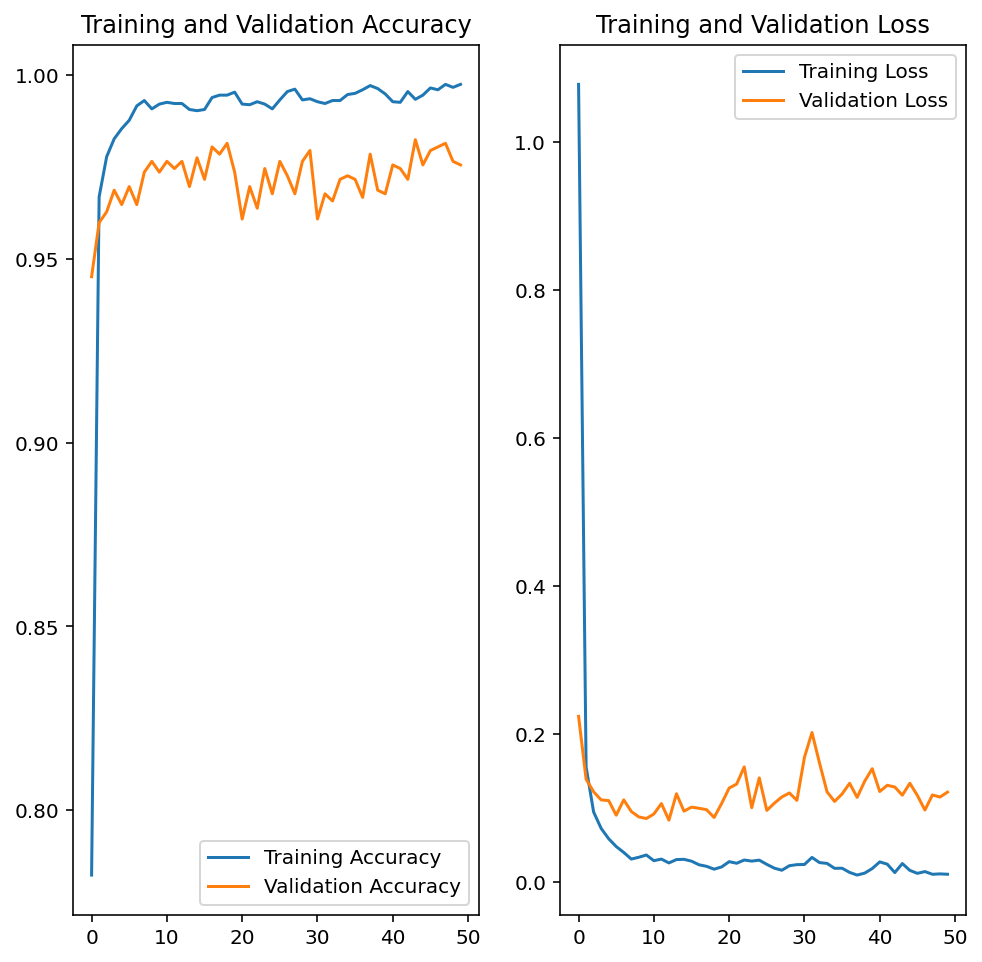

In [ ]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model_3.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

32/32 [==============================] - 7s 194ms/step - loss: 0.1478 - accuracy: 0.9657

Loss on the TEST Set: 0.148
Accuracy on the TEST Set: 96.569%


## resnet_50

In [ ]:
model_4 = tf.keras.Sequential(resnet_50)
#model_3.add(Dense(3456, activation='relu', kernel_initializer='he_uniform'))
model_4.add(Dense(no_of_classes, kernel_regularizer='l1_l2',activation = 'softmax'))


In [ ]:
model_4.compile(optimizer = "nadam",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model_4.fit(training_batches,
                    epochs = 50,
                    validation_data=validation_batches,
                    #callbacks=[early_stopping]
                    )

Epoch 1/50
193/193 [==============================] - 92s 238ms/step - loss: 0.9076 - accuracy: 0.8239 - val_loss: 0.1765 - val_accuracy: 0.9676
Epoch 2/50
193/193 [==============================] - 44s 229ms/step - loss: 0.0750 - accuracy: 0.9863 - val_loss: 0.1344 - val_accuracy: 0.9696
Epoch 3/50
193/193 [==============================] - 44s 227ms/step - loss: 0.0332 - accuracy: 0.9963 - val_loss: 0.1798 - val_accuracy: 0.9569
Epoch 4/50
193/193 [==============================] - 44s 228ms/step - loss: 0.0220 - accuracy: 0.9976 - val_loss: 0.1021 - val_accuracy: 0.9745
Epoch 5/50
193/193 [==============================] - 44s 229ms/step - loss: 0.0144 - accuracy: 0.9989 - val_loss: 0.0973 - val_accuracy: 0.9765
Epoch 6/50
193/193 [==============================] - 44s 227ms/step - loss: 0.0112 - accuracy: 0.9989 - val_loss: 0.0979 - val_accuracy: 0.9765
Epoch 7/50
193/193 [==============================] - 44s 229ms/step - loss: 0.0106 - accuracy: 0.9987 - val_loss: 0.0975 - val_ac

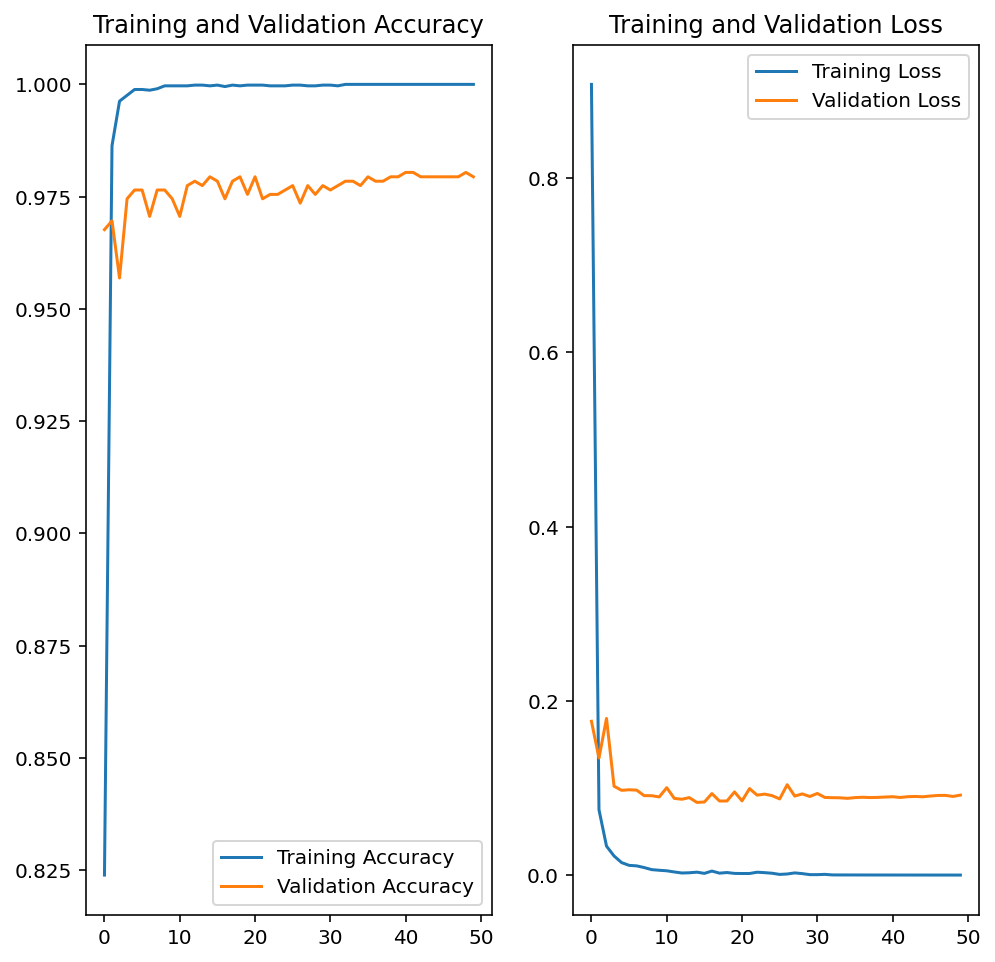

In [ ]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_loss))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Print the loss and accuracy values achieved on the entire test set.

loss, accuracy = model_4.evaluate(testing_batches)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss))
print('Accuracy on the TEST Set: {:.3%}'.format(accuracy))

32/32 [==============================] - 7s 207ms/step - loss: 0.1026 - accuracy: 0.9824

Loss on the TEST Set: 0.103
Accuracy on the TEST Set: 98.235%


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [ ]:
# Save your trained model as a Keras model.
from time import time

t = time()

saved_keras_model_filepath = 'Saved.h5'

model.save(saved_keras_model_filepath)

## Load the Keras Model

Load the Keras model you saved above.

In [ ]:
# Load the Keras model

reloaded_keras_model = tf.keras.models.load_model('Saved1614679018.h5' , custom_objects={'KerasLayer':hub.KerasLayer})

reloaded_keras_model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_9 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_8 (Dense)              (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________


# Inference for Classification


```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [ ]:
# Create the process_image function
def process_image(image):
    image = tf.image.resize(image, (224, 224)) 
    image = tf.cast(image, tf.float32)
    image /= 255
    image=image.numpy()
    return image


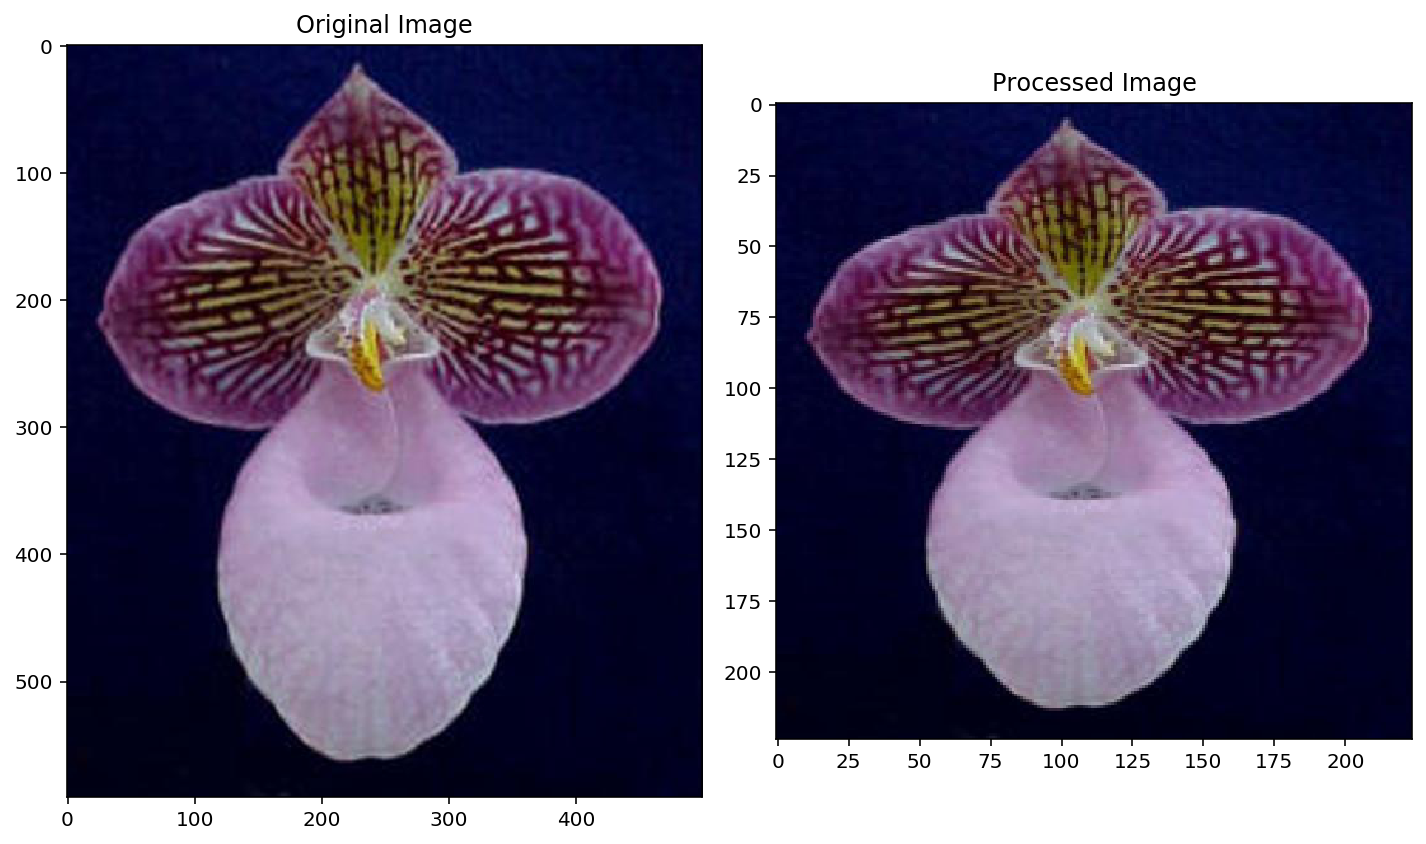

In [ ]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [ ]:
# Create the predict function
def predict(image_path, model, top_k):
    im = Image.open(image_path)
    image = np.asarray(im)
    processed_image = process_image(image)
    processed_image = np.expand_dims(processed_image, axis = 0)
    ps=model.predict(processed_image)
    k_values, k_indices= tf.math.top_k(ps, k=top_k)
    probs=k_values
    classes=k_indices
    probs = k_values.numpy().squeeze()
    classes = k_indices.numpy().squeeze().astype(str)
    #probs= np.array(probs)
    #classes= np.array(classes).astype(str)
    return probs,classes

In [ ]:
probs, classes = predict(image_path, reloaded_keras_model, 5)
print(probs)
print(classes)

[9.9040341e-01 2.4068109e-03 1.0132724e-03 9.1677433e-04 7.3390076e-04]
['1' '67' '6' '5' '79']




In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:


<img src='https://drive.google.com/uc?id=1sgcTVdtskFoe5AQPhA6KJ39di2RdmRyA' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

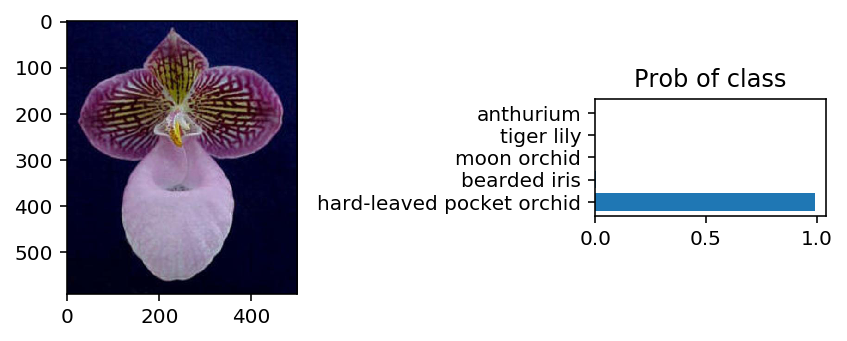

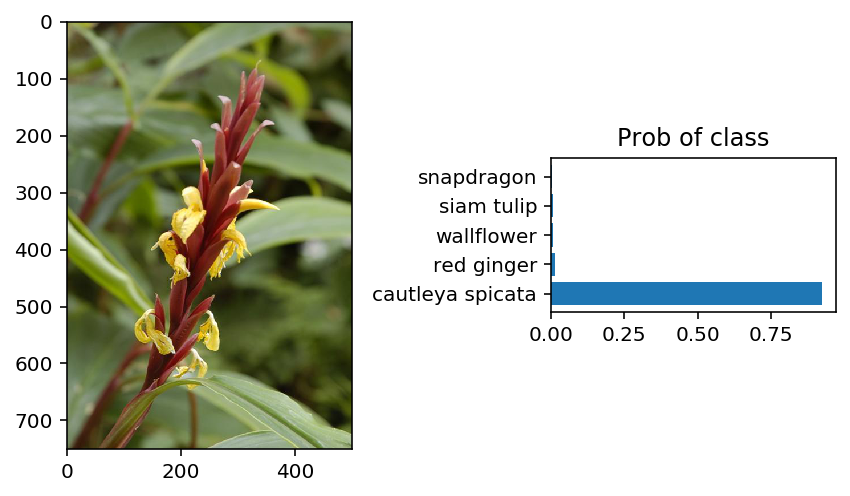

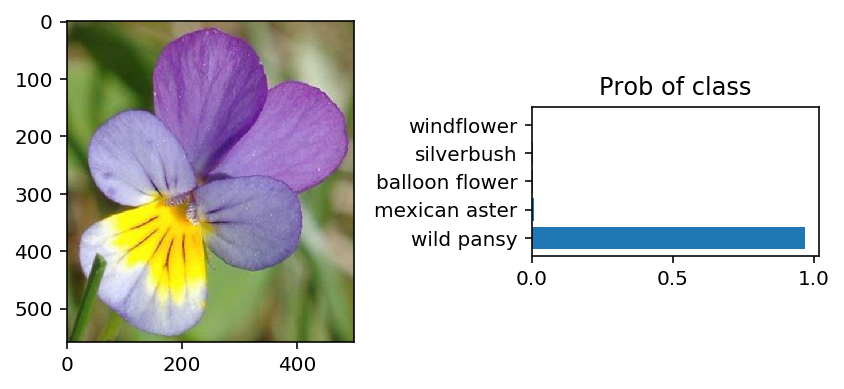

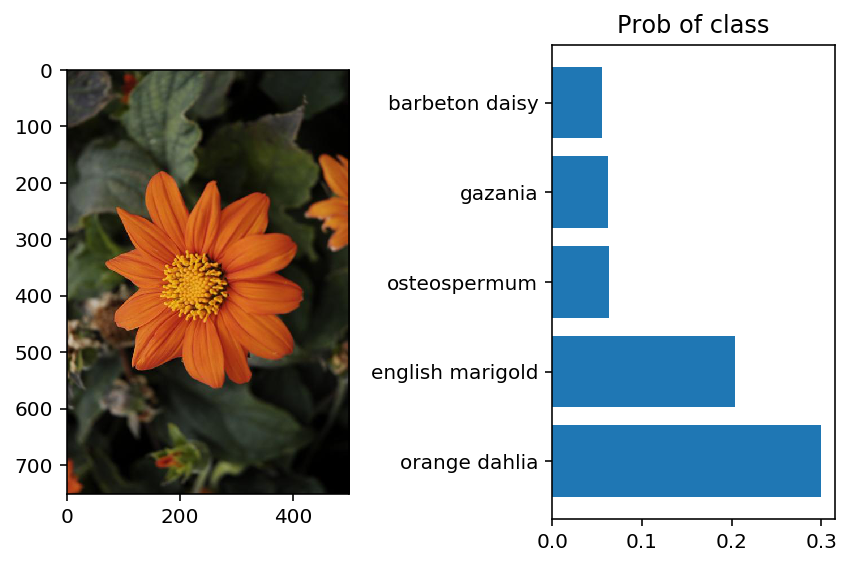

In [ ]:

def img_prob(image_path, top_k):

    p,c = predict(image_path, reloaded_keras_model,top_k)
    img = Image.open(image_path)
    test_image = np.asarray(img)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,6), ncols=2)
    ax1.imshow(test_image, cmap = plt.cm.binary)
    ax2.barh(range(top_k),p)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(top_k))
    
    # Class_names map defined within json file
    #ax2.set_yticklabels([class_names[x+1] for x in c])
    ax2.set_yticklabels([class_names[str(int(x)+1)] for x in c])
    ax2.set_title('Prob of class')
    plt.tight_layout()

# Iterate through imgs in test_images    
for i in glob.glob("./test_images//*.jpg"):
    img_prob(i,5)